<a href="https://colab.research.google.com/github/SzymonNowakowski/Machine-Learning-2024/blob/master/Lab13-towards-self-attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 13 - Towards Self-Attention (*pl. Samoatencja*)


### Author: Szymon Nowakowski


# Introduction
---------------

In this class, we build on our understanding of attention by introducing **self-attention**—a powerful mechanism that allows each word in a sentence to attend to **every other word**, including itself. While basic attention required an external query (e.g., from a classifier or decoder), self-attention uses the words within a sequence to compute their mutual influence, enabling the model to capture dependencies regardless of distance or position.

This mechanism lies at the heart of modern architectures like the Transformer. By the end of this class, you’ll understand how self-attention works, how it differs from earlier forms of attention, and why it enables models to process sequences in parallel while preserving word-to-word relationships.

In our next class, we’ll combine self-attention with other components—like feedforward layers and residual connections—to build the full Transformer architecture.




## Acknowledgments

*I would like to express my gratitude to my colleague **Przemysław Olbratowski** for this elegant way of introducing attention, which I find both intuitive and pedagogically effective.*

# Yelp Reviews Polarity Dataset  
--------------

We shall continue to work with **Yelp Reviews Polarity Dataset**.

This dataset contains **over 560k full-text reviews** from Yelp, labeled for **binary sentiment**:  
- **positive** (5-star reviews)  
- **negative** (1-star reviews)  

We will not use the full dataset, because it cannot be handled by Colab RAM.

Each example is a **real user-generated review**, typically 2–5 sentences long, capturing clear and direct sentiment in natural language.  
There are no ambiguous or neutral labels, making this dataset ideal for training and evaluating **binary sentiment classifiers**.

The dataset was curated and released as part of the **FastText** and **Text Classification Benchmarks** by researchers at Facebook AI. It is widely used for benchmarking sentiment models in both academia and industry.


In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == 

In [2]:
from datasets import load_dataset
import collections
import re                             # Regular Expressions: for text searching and cleaning

MAX_LEN = 128

# Load Yelp Polarity dataset from Hugging Face (one-time use)
raw = load_dataset("yelp_polarity")

N_TRAIN = 100_000
N_TEST = 20_000   # VAL + TEST sets

train_raw = raw["train"].shuffle(seed=42).select(range(N_TRAIN))
test_raw  = raw["test"].shuffle(seed=42).select(range(N_TEST))


# Extract plain Python lists for text and labels
def to_lists(dataset):
    texts = []
    labels = []
    for example in dataset:
        texts.append(example["text"])
        labels.append(example["label"])
    return texts, labels

train_texts, train_labels = to_lists(train_raw)
test_texts, test_labels   = to_lists(test_raw)

# Split test set into val/test
from sklearn.model_selection import train_test_split
val_texts, test_texts, val_labels, test_labels = train_test_split(
    test_texts, test_labels, test_size=0.5, random_state=42
)

# Show class counts
def print_distribution(name, labels):
    c = collections.Counter(labels)
    total = sum(c.values())
    print(f"\n{name} distribution:")
    for label in sorted(c.keys()):
        print(f"  {label}: {c[label]} ({c[label]/total:.2%})")

print_distribution("Train", train_labels)
print_distribution("Validation", val_labels)
print_distribution("Test", test_labels)

label_map = {0: "negative", 1: "positive"}


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.93k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/256M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/560000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/38000 [00:00<?, ? examples/s]


Train distribution:
  0: 50209 (50.21%)
  1: 49791 (49.79%)

Validation distribution:
  0: 5038 (50.38%)
  1: 4962 (49.62%)

Test distribution:
  0: 4973 (49.73%)
  1: 5027 (50.27%)


# Adding Artificial (Concatenated) Sentences
-----------------

Working with the same dataset provides a practical benchmark: we can now assess whether using more sophisticated attention mechanisms (such as self-attention) leads to measurable improvements over simpler approaches like mean-pooling or fixed attention.

**To recap:**

In this augmentation strategy, each original sentence is placed at the end of a newly formed input, preceded by a randomly chosen distractor sentence. The original label is retained, ensuring that every new example remains correctly annotated. This approach doubles the dataset size (token-wise) while preserving both the number of samples and the overall label distribution.

The task now becomes more focused: the model must learn to attend to the main sentence and ignore the irrelevant prefix.

- **With attention**: the model can assign higher weights to the meaningful part of the input and suppress noise, including any trailing `<PAD>` tokens.
- **Without attention**: a mean-pooling model processes all tokens equally, making it harder to isolate the signal from the noise introduced by the distractor.

In [3]:
import random

MAX_LEN = 256  # changing max len to accomodate longer sequences, also, longer sequences are harder for the mean network

def pair_every_sentence_with_random(texts, labels, seed=42):
    """
    For each sentence, append a randomly selected second sentence.
    The label of the first is preserved.
    """
    random.seed(seed)
    n = len(texts)

    augmented_texts = []
    augmented_labels = []

    for i in range(n):
        first = texts[i]
        label = labels[i]

        second = texts[random.randint(0, n - 1)]

        combined = second + " <SEP> " + first # we prepend the sentence with a random one, now

        augmented_texts.append(combined)
        augmented_labels.append(label)

    return texts + augmented_texts, labels + augmented_labels


train_texts, train_labels = pair_every_sentence_with_random(train_texts, train_labels)
val_texts, val_labels     = pair_every_sentence_with_random(val_texts,   val_labels)
test_texts, test_labels   = pair_every_sentence_with_random(test_texts,  test_labels)


# Tokenizer
-------------------

We shall also reuse the same tokenizer.

In [4]:
def tokenize(text):
    text = text.lower()
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.split()

def build_vocab(token_lists, min_freq=2):
    counter = collections.Counter(token for tokens in token_lists for token in tokens)
    vocab = {
        token: idx + 2  # reserve 0: <PAD>, 1: <UNK>
        for idx, (token, count) in enumerate(counter.items())
        if count >= min_freq
    }
    vocab['<PAD>'] = 0
    vocab['<UNK>'] = 1
    return vocab

def tokens_to_ids(tokens, vocab):
    return [vocab.get(tok, vocab['<UNK>']) for tok in tokens]   #for unknown tokens return vocab['<UNK>'] (which is == 1)

def pad(seq, max_len=128, pad_value=0):
    return seq + [pad_value] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len]

def process_texts(texts, vocab, max_len=128):
    return [pad(tokens_to_ids(tokenize(text), vocab), max_len) for text in texts]


# Tokenize training set and build vocab
train_tokens = [tokenize(t) for t in train_texts]
vocab = build_vocab(train_tokens)

# Process splits into padded input_ids
train_ids = process_texts(train_texts, vocab, MAX_LEN)
val_ids   = process_texts(val_texts, vocab, MAX_LEN)
test_ids  = process_texts(test_texts, vocab, MAX_LEN)

# Print 5 real examples: raw text, tokenized, and input IDs
shown = 0
for i in range(len(train_texts)):
    if 1 in train_ids[i][:5]:  # 1 is <UNK>
        print(f"Original:   {train_texts[i]}")
        print(f"Tokenized:  {train_tokens[i]}")
        print(f"Input IDs:  {train_ids[i]}\n")
        shown += 1
        if shown >= 5:
            break





# Data Loaders, Training Loop and Plotting
--------------------

We reuse those as well.

## Data Loaders

In [5]:
import torch

BATCH_SIZE = 1024

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Convert all to tensors
def to_loader(input_ids, labels, batch_size=1024, shuffle=False):
    x_tensor = torch.tensor(input_ids, dtype=torch.long)
    y_tensor = torch.tensor(labels, dtype=torch.long)
    return torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_tensor, y_tensor), batch_size=batch_size, shuffle=shuffle)

train_loader = to_loader(train_ids, train_labels, BATCH_SIZE, shuffle=True)
val_loader   = to_loader(val_ids, val_labels, BATCH_SIZE)
test_loader  = to_loader(test_ids, test_labels, BATCH_SIZE)


## Train Loop Function

In [6]:
import time
import torch
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

def train_model(net, train_loader, val_loader, epochs=1000, lr=0.001, log_every=10):
    print(f"Working on {device}")
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()

    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    start_time = time.time()

    for epoch in range(epochs):
        net.train()
        train_loss_sum = 0.0
        train_correct = 0
        train_total = 0

        for batch_inputs, batch_labels in train_loader:
            batch_inputs = batch_inputs.to(device)
            batch_labels = batch_labels.to(device).float()  # shape: (batch_size)

            optimizer.zero_grad()
            logits = net(batch_inputs)  # logits shape: (batch_size, 1)
            loss = criterion(logits, batch_labels)
            loss.backward()
            optimizer.step()

            train_loss_sum += loss.item() * batch_inputs.size(0)
            preds = (torch.sigmoid(logits) > 0.5).float()
            train_correct += (preds == batch_labels).sum().item()
            train_total += batch_inputs.size(0)

        avg_train_loss = train_loss_sum / train_total
        train_acc = train_correct / train_total
        train_loss_history.append(avg_train_loss)
        train_acc_history.append(train_acc)

        # === Validation ===
        net.eval()
        val_loss_sum = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch_inputs, batch_labels in val_loader:
                batch_inputs = batch_inputs.to(device)
                batch_labels = batch_labels.to(device).float()

                logits = net(batch_inputs)
                loss = criterion(logits, batch_labels)

                val_loss_sum += loss.item() * batch_inputs.size(0)
                preds = (torch.sigmoid(logits) > 0.5).float()
                val_correct += (preds == batch_labels).sum().item()
                val_total += batch_inputs.size(0)

        avg_val_loss = val_loss_sum / val_total
        val_acc = val_correct / val_total
        val_loss_history.append(avg_val_loss)
        val_acc_history.append(val_acc)

        if epoch % log_every == 0:
            print(f"Epoch {epoch:03d} | "
                  f"Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.4f} | "
                  f"Val Loss: {avg_val_loss:.4f}, Acc: {val_acc:.4f}")

    end_time = time.time()
    print(f"Elapsed time: {end_time - start_time:.2f} seconds")

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

Working on cuda


## Plot Function

In [7]:
import matplotlib.pyplot as plt

def plot_training_curves(train_loss, val_loss, train_acc, val_acc):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Loss
    axs[0].plot(train_loss, label="Train Loss", color='blue')
    axs[0].plot(val_loss, label="Val Loss", color='orange')
    axs[0].set_title("Loss per Epoch")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Average Loss")
    axs[0].grid(True)
    axs[0].legend()

    # Plot Accuracy
    axs[1].plot(train_acc, label="Train Accuracy", color='green')
    axs[1].plot(val_acc, label="Val Accuracy", color='red')
    axs[1].set_title("Accuracy per Epoch")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].grid(True)
    axs[1].legend()

    plt.tight_layout()
    plt.show()

# Positional Encoding
-----------------------

We shall also reuse positional encoding.

In [8]:
import torch

pos_cnt = 16
positional_encoding_B = 1000

def sinusoid_positions(max_len = MAX_LEN, dim = pos_cnt):
    pos = torch.arange(max_len, device=device).float().unsqueeze(1)
    i   = torch.arange(dim, device=device).float().unsqueeze(0)
    angle = pos / (positional_encoding_B ** (2 * (i//2) / dim))
    S = torch.zeros(max_len, dim, device=device)
    S[:, 0::2] = torch.sin(angle[:, 0::2])
    S[:, 1::2] = torch.cos(angle[:, 1::2])
    return S          #  SIZE: words, features  (constant matrix throuoght all computations)



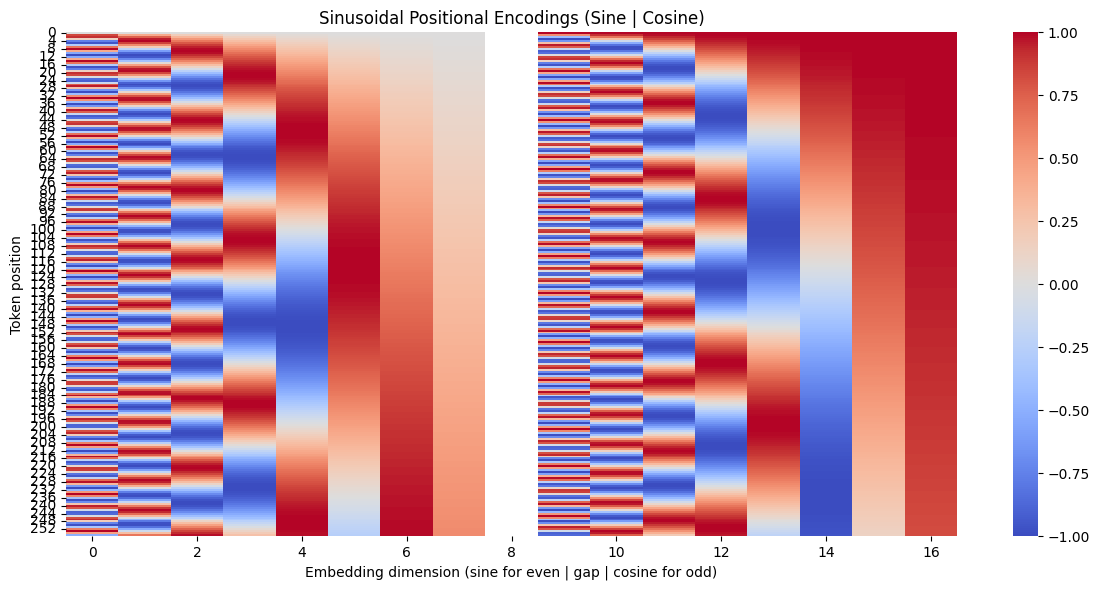

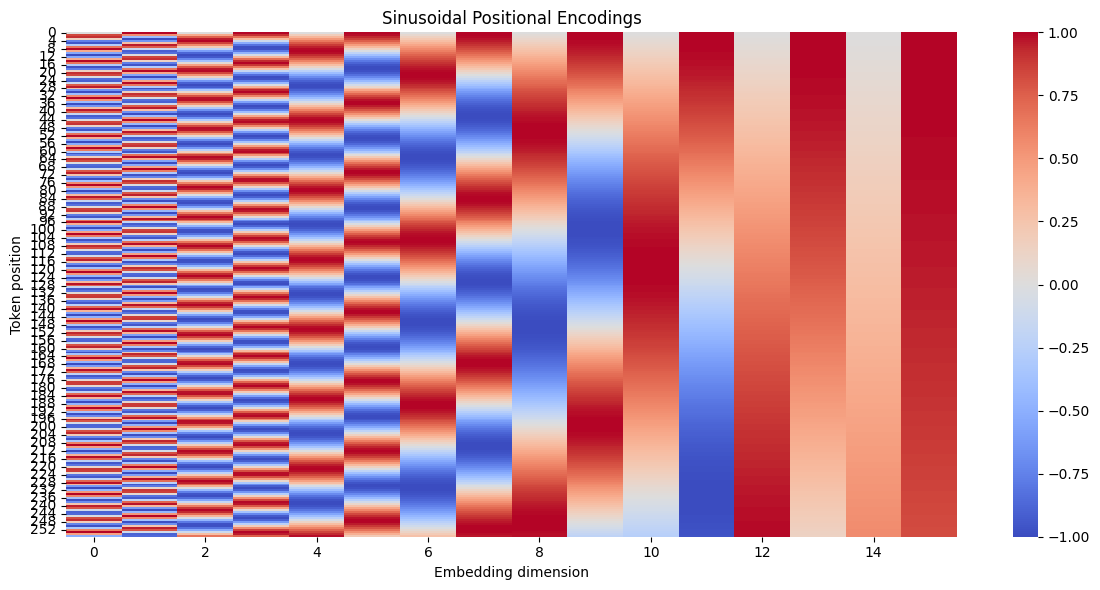

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create sinusoidal matrix S
S = sinusoid_positions() # size: words, features

# Separate sine (even) and cosine (odd) components
sine = S[:, ::2]
cosine = S[:, 1::2]
gap = torch.full((S.size(0), 1), float('nan')).to(device)  # vertical separator

# Concatenate: [sine | gap | cosine]
S_sep = torch.cat([sine, gap, cosine], dim=1)

# Plot as heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(S_sep.cpu().numpy(), cmap="coolwarm", cbar=True, xticklabels=2, yticklabels=4)
plt.title("Sinusoidal Positional Encodings (Sine | Cosine)")
plt.xlabel("Embedding dimension (sine for even | gap | cosine for odd)")
plt.ylabel("Token position")
plt.tight_layout()
plt.show()

# Plot as heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(S.cpu().numpy(), cmap="coolwarm", cbar=True, xticklabels=2, yticklabels=4)
plt.title("Sinusoidal Positional Encodings")
plt.xlabel("Embedding dimension")
plt.ylabel("Token position")
plt.tight_layout()
plt.show()



# Recall the Attention Network
-----------------------

Working on cuda
Epoch 000 | Train Loss: 0.6787, Acc: 0.5727 | Val Loss: 0.6587, Acc: 0.6331
Epoch 010 | Train Loss: 0.3462, Acc: 0.8552 | Val Loss: 0.3757, Acc: 0.8390
Elapsed time: 76.80 seconds


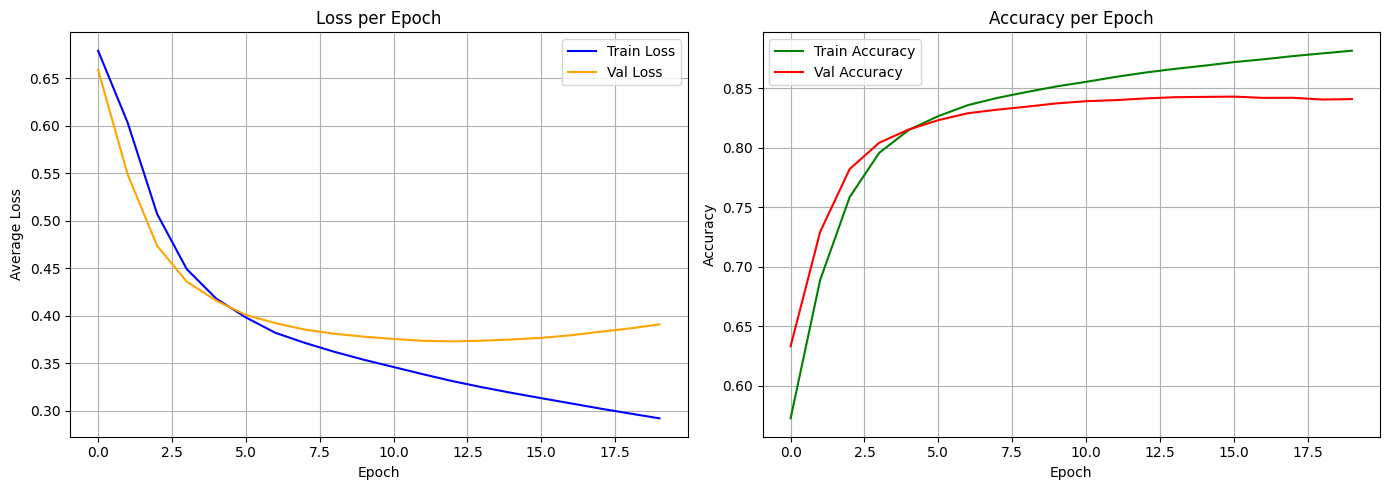

In [10]:
embed_cnt = 16          # word embeddings
pos_cnt = 16            # pos embeddings
feature_cnt = 16

vocab_len = max(vocab.values()) + 1   # maximal value (index) of a token

class Attention(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.energy = torch.nn.Linear(feature_cnt, 1)
    def forward(self, features):                        #SIZE: batch, words, features
        batch = features.size(0)          # get the batch dimension
        words = features.size(1)          # get the words dimension
        energies = self.energy(features)                #SIZE: batch, words, 1
        energies = energies.transpose(-2, -1)           #SIZE: batch, 1, words
        weights = F.softmax(energies, -1)               #SIZE: batch, 1, words
        features = weights @ features                   #SIZE: batch, 1, features
        return features

class Net_Attention_And_PE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_len, embed_cnt)
        self.attention = Attention()
        self.classifier = torch.nn.Linear(feature_cnt, 1)
    def forward(self, index):                            #SIZE: batch, words
        features = self.embedding(index) + S             #SIZE: batch, words, features

        ### This is where WHEIGHTED AVERAGING with LEARNED WEIGHTS takes place
        features = self.attention(features)              #SIZE: batch, 1, features

        classifications = self.classifier(features)      #SIZE: batch, 1, 1
        logits = classifications.squeeze(-1).squeeze(-1) #SIZE: batch
        return logits

net_att_pe = Net_Attention_And_PE()

# Execute training again
train_loss, val_loss, train_acc, val_acc = train_model(net_att_pe, train_loader, val_loader, epochs = 20)
plot_training_curves(train_loss, val_loss, train_acc, val_acc)

# Towards Self-Attention!
--------------------

We'll follow the same gradual approach as in the previous class.

At first, some changes may seem minor—perhaps even redundant—sometimes resulting in models that are equivalent, or worse: equivalent *and* overparameterized. But each step brings us closer to our goal.

And then, with one decisive twist, everything will fall into place.

So off we go!


## Introducing the Query and the Keys


So far, our attention mechanism has relied on letting the **Query** (which we previously called ***Energy*** but it is the same thing\) attend directly to the feature representations. But what if those raw features aren't always in the best form for comparison?

Instead of having the Query interact with features directly, we can transform each feature into a new vector—one that’s specifically designed to interact with the Query. This brings us to the concept of **Keys**.

Keys are learned projections of features that serve as their "presentation" when being evaluated by a Query. The idea is that attention will work better when both the **thing doing the looking** (Query) and the **thing being looked at** (Key) speak the same language.

Formally, we define the Key as:

$$
\text{key} = \text{feature} \cdot K
$$

where $K$ is a learnable matrix of shape $d \times d$, and $d$ is the dimensionality of the input features.


In [11]:
embed_cnt = 16          # word embeddings
pos_cnt = 16            # pos embeddings
feature_cnt = 16

vocab_len = max(vocab.values()) + 1   # maximal value (index) of a token

class Attention_With_Keys(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.query = torch.nn.Linear(feature_cnt, 1)            # rename energy to query from now on
        self.K = torch.nn.Linear(feature_cnt, feature_cnt)      # and introduce the K (key) matrix d x d
    def forward(self, features):                        #SIZE: batch, words, features
        batch = features.size(0)          # get the batch dimension
        words = features.size(1)          # get the words dimension
        keys = self.K(features)                         #SIZE: batch, words, features
        energies = self.query(keys)                     #SIZE: batch, words, 1
        energies = energies.transpose(-2, -1)           #SIZE: batch, 1, words
        weights = F.softmax(energies, -1)               #SIZE: batch, 1, words
        features = weights @ features                   #SIZE: batch, 1, features
        return features

class Net_Attention_With_Keys(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_len, embed_cnt)
        self.attention = Attention_With_Keys()
        self.classifier = torch.nn.Linear(feature_cnt, 1)
    def forward(self, index):                            #SIZE: batch, words
        features = self.embedding(index) + S             #SIZE: batch, words, features

        ### This is where WHEIGHTED AVERAGING with LEARNED WEIGHTS takes place
        features = self.attention(features)              #SIZE: batch, 1, features

        classifications = self.classifier(features)      #SIZE: batch, 1, 1
        logits = classifications.squeeze(-1).squeeze(-1) #SIZE: batch
        return logits


### Task

Obviously, this query-key formulation is not only equivalent to the regular energy-focused attention. It is redundant in terms of parameters. Do you see that?



### Query-Key vs. Energy Formulation Comparison

Let’s compare two formulations for computing attention energies from feature vectors.


#### Query-Key Factorized Version

In our current model, we compute:

$$
\text{keys} = \text{features} \cdot K \\
\text{energies} = \text{keys} \cdot q = (\text{features} \cdot K) \cdot q = \text{features} \cdot (K \cdot q)
$$

So although we introduce **Keys** and **Queries** explicitly, the final result is still a single linear projection of the original features:

$$
\text{energies} = \text{features} \cdot W, \quad \text{where} \quad W = K \cdot q
$$

This is functionally equivalent to the classic **energy-only** attention mechanism.


#### Parameter Count

Let $d$ be the dimensionality of the features (i.e., `feature_cnt`).

- **Query-Key version:**
  - $K$: a $d \times d$ matrix, resulting in $d^2$ parameters
  - $q$: a $d \times 1$ vector, resulting in $d$ parameters  
  
  **Total: $d^2 + d$ parameters**

- **Energy-only version:**
  - A single linear layer from features to scalar
  
  **Total: $d$ parameters**

So, in this setup, the query-key formulation has **$d^2$ more parameters** than necessary and is **strictly overparameterized**.





#### Conclusion

This setup offers **no additional expressivity**. In fact, unless carefully initialized or regularized, it can make learning harder and less stable due to the redundant parameterization.


### Low-Rank Factorization

Not all is lost. By carefully controlling the dimensionality of the **Key space**, we can reduce the number of parameters and limit overparameterization.

Let’s introduce a **low-rank factorization**:

- $K$: a $d \times k$ matrix  
- $q$: a $k \times 1$ vector  
- where $k < d$

Then the energy computation becomes:

$$
\text{keys} = \text{features} \cdot K  \\
\text{energies} = \text{keys} \cdot q = \text{features} \cdot (K \cdot q)
$$

So again:

$$
\text{energies} = \text{features} \cdot W, \quad \text{with } W = K \cdot q \in \mathbb{R}^{d \times 1}
$$



####  Parameter Count

Let’s compare the number of parameters:

- **Low-rank query-key version:**
  - $K$: $d \times k$ → $dk$ parameters
  - $q$: $k \times 1$ → $k$ parameters  
  **Total: $dk + k$ parameters**

- **Original energy-only version:**
  - One linear projection: $d$ parameters

Notably, when $k = 1$, the number of parameters becomes:

  $$
  d \cdot 1 + 1 = d + 1
  $$

  —which **exactly matches** the parameter count of the original energy-only formulation with a single linear projection.


#### Conclusion

We started off with a version that was **theoretically equivalent but practically worse** than the original energy-based attention. By factorizing the energy computation into separate **Key** and **Query** components without reducing dimensionality, we introduced unnecessary overparameterization—making the model **less stable** and harder to train.

However, this detour was not without value: it led us to a more flexible and efficient formulation. By **reducing the dimensionality** of the key space (i.e., using a smaller $k$), we arrive at a **low-rank factorization** that:

- Matches the original model’s parameter count when $k = 1$,
- And enables richer attention structures when $k > 1$.

So while our initial formulation was redundant, it ultimately revealed a **useful and scalable path forward**.

We will not be training this version, as thanks to this careful analysis, we do not expect nothing valuable to come out of it.


## Introducing Queries

Up to now, we’ve used a **single, global query** to compute attention scores over all tokens in the sequence. This gave us a fixed viewpoint—useful for tasks like classification—but it limited the model's ability to express interactions between tokens.

In **self-attention**, we take this idea further: **each token generates its own query**.

A **Query** is a learned projection of a token’s features that expresses **what this token is looking for**. Instead of one global viewpoint, every token forms its own question and compares it against the rest of the sequence.

To do this, we introduce a learnable matrix $Q$ of shape $d \times k$, where:
- $d$ is the dimensionality of the feature vector,
- $k$ is the dimensionality of the shared **query and key space**.

Each query is computed as:

$$
\text{query} = \text{feature} \cdot Q
$$

Likewise, each key is computed as:

$$
\text{key} = \text{feature} \cdot K
$$

where $K$ is another learned matrix of shape $d \times k$.

We then compute attention scores using a dot product between the query of one token and the keys of all tokens in the sequence:

$$
\text{energy}_{i,j} = \text{query}_i \cdot \text{key}_j
$$

This produces a separate attention distribution **for each token**—each one deciding independently which other tokens to attend to.

This mechanism is the heart of self-attention: it turns every token into an active agent that selectively gathers information from its surroundings.


### Matrix Formulation


Let’s now express this more generally in matrix form.

Let:
- $F \in \mathbb{R}^{n \times d}$ be the matrix of input features (for $n$ tokens, each of dimension $d$),
- $Q \in \mathbb{R}^{d \times k}$ be the **query projection matrix**,
- $K \in \mathbb{R}^{d \times k}$ be the **key projection matrix**.

We compute:
- Queries: $F Q \in \mathbb{R}^{n \times k}$
- Keys: $F K \in \mathbb{R}^{n \times k}$

The attention **energy matrix** is then:

$$
E = (F Q)(F K)^\top \in \mathbb{R}^{n \times n}
$$

Now comes the crucial observation:

We can factor the expression as:

$$
E = F (Q K^\top) F^\top
$$

This shows that the full $n \times n$ energy matrix is a **quadratic form** defined by the product $Q K^\top \in \mathbb{R}^{d \times d}$.



### Parameter Count

- $Q$: $d \times k$, resulting in $dk$ parameters  
- $K$: $d \times k$, resulting in $dk$ parameters  

**Total: $2dk$ parameters**

- The matrix $Q K^\top \in \mathbb{R}^{d \times d}$ is a **learned, structured weight matrix**, but it is **not arbitrary** — it is parameterized by just $2dk$ parameters, not $d^2$.

So although $Q K^\top$ is a $d \times d$ matrix, it has **rank at most $k$**, and it is **not directly learned**, but **composed** from two lower-rank projections.

### Conclusion

- The energy matrix $E \in \mathbb{R}^{n \times n}$ is expressed as:
  $$
  E = F (Q K^\top) F^\top
  $$
- This shows that attention energies are governed by a **global bilinear interaction** over the features.
- The structure $Q K^\top$ has rank at most $k$ and is fully determined by $2dk$ parameters.
- For $k \ll d$, this formulation yields a **low-rank attention mechanism** that is both expressive and efficient — far more efficient than a full, unconstrained $d \times d$ attention matrix.

Working on cuda
Epoch 000 | Train Loss: 0.6819, Acc: 0.5506 | Val Loss: 0.6579, Acc: 0.6131
Epoch 010 | Train Loss: 0.3463, Acc: 0.8541 | Val Loss: 0.3729, Acc: 0.8405
Elapsed time: 168.48 seconds


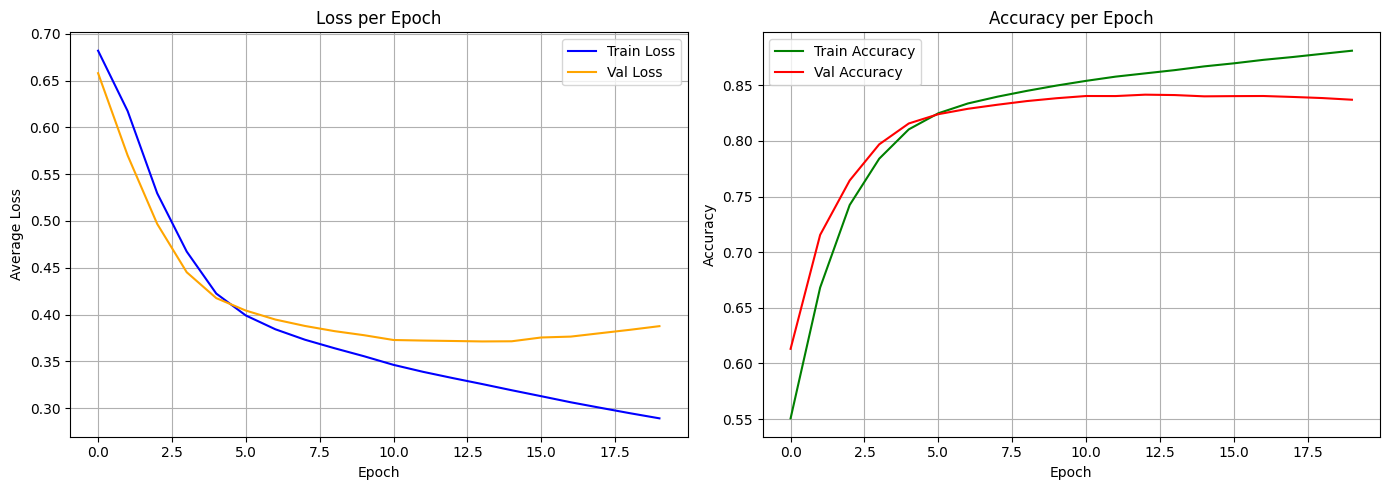

In [12]:
embed_cnt = 16          # word embedding dimension
pos_cnt = 16            # positional encoding dimension
feature_cnt = 16        # total feature dimension (d)
k = 8                   # query/key dimension (low-rank)

vocab_len = max(vocab.values()) + 1  # maximal value (index) of a token

class SelfAttention_QK(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.Q = torch.nn.Linear(feature_cnt, k)        # query projection d x k
        self.K = torch.nn.Linear(feature_cnt, k)        # key projection d x k

    def forward(self, features):                        # size: batch, words, d
        queries = self.Q(features)                      # size: batch, words, k
        keys = self.K(features)                         # size: batch, words, k

        # Compute energy scores:
        energies = queries @ keys.transpose(-2, -1)     # size: batch, words, words
        energies = energies / (k ** 0.5)                # it is an additional rescale helping the stability

        # Normalize energies into attention weights
        attention = F.softmax(energies, dim=-1)         # size: batch, words, words

        # Apply attention weights to values:
        output = attention @ features                   # size: batch, words, d

        return output

class Net_SelfAttention_QK(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_len, embed_cnt)
        self.attention = SelfAttention_QK()
        self.classifier = torch.nn.Linear(feature_cnt, 1)

    def forward(self, index):                            # size: batch, words
        features = self.embedding(index) + S             # size: batch, words, d

        # Attend and pool original features using attention weights
        attended = self.attention(features)              # size: batch, words, d
        pooled = attended.mean(dim = -2)                 # size: batch, d  # average across words

        output = self.classifier(pooled)                 # size: batch, 1
        logits = output.squeeze(-1)                      # size: batch
        return logits

# Instantiate and train
net_att_qk = Net_SelfAttention_QK()
train_loss, val_loss, train_acc, val_acc = train_model(net_att_qk, train_loader, val_loader, epochs=20)
plot_training_curves(train_loss, val_loss, train_acc, val_acc)


### Why divide by $\sqrt{k}$?

Recall that attention energies are computed as:

$$
\text{energy}_{i,j} = \text{query}_i \cdot \text{key}_j = \sum_{l=1}^{k} q_{i,l} \cdot k_{j,l}
$$

This is an unnormalized dot product of two $k$-dimensional vectors.

Assume:

$$
q_{i,l} \sim \mathcal{N}(0, \sigma^2), \quad k_{j,l} \sim \mathcal{N}(0, \sigma^2)
$$

Then the dot product is a sum of $k$ independent products, so its variance is proportional to $k$:

$$
\text{Var}(q_i \cdot k_j) \propto k
$$



**What goes wrong without scaling?**

As $k$ increases, the magnitude of these raw energies grows. When passed through the softmax, this leads to **very sharp distributions** — with outputs close to 0 or 1. This causes:

- Vanishing gradients in early training,
- Unstable or brittle updates,
- Poor generalization.



**The fix: divide by $\sqrt{k}$**

To stabilize this, we rescale the energies:

$$
\text{energy}_{i,j} = \frac{q_i \cdot k_j}{\sqrt{k}}
$$

This keeps the scale of energies roughly constant as $k$ grows, ensuring that softmax remains smooth and gradients stay usable.

This was introduced in the original Transformer paper: *Attention is All You Need*, so we introduce it a bit early, but we want the training to be stable.

## Introducing Values

So far, we’ve seen how **Queries** and **Keys** determine *where* attention should be paid — that is, which tokens are relevant to each other. But once the model has computed these attention **energies**, what exactly is being retrieved?

This is the role of **Values**.

Each token is associated with a **value vector** — a projection of its features that represents the *content* it offers if attended to. These are computed just like queries and keys:

$$
\text{value} = \text{feature} \cdot V
$$

where:
- $\text{feature} \in \mathbb{R}^d$ is the input feature vector for a single token,
- $V \in \mathbb{R}^{d \times d_v}$ is a learnable weight matrix,
- $\text{value} \in \mathbb{R}^{d_v}$ is the resulting value vector.

For a batch of $n$ tokens, this gives:

$$
\text{values} = F \cdot V \in \mathbb{R}^{n \times d_v}
$$

The attention mechanism computes a matrix of **energies**:

$$
E = F \cdot (QK^\top) \cdot F^\top \in \mathbb{R}^{n \times n}
$$

These energies encode which tokens should influence each other — but not what is being transferred. To actually compute the result of attention, we combine these (after row-wise normalization) with the value vectors:

$$
\text{output} = \text{weights} \cdot \text{values}
$$

where `weights` is obtained from $E$ by applying softmax or another normalization function row-wise.



### Conclusion

Now we have transitioned to self-attention, where each token gets:

- Its own query (what it's looking for),
- Its own key (how it presents itself),
- Its own value (what it offers if attended to)

Working on cuda
Epoch 000 | Train Loss: 0.6732, Acc: 0.5746 | Val Loss: 0.6098, Acc: 0.6724
Epoch 010 | Train Loss: 0.3423, Acc: 0.8533 | Val Loss: 0.3800, Acc: 0.8337
Elapsed time: 173.08 seconds


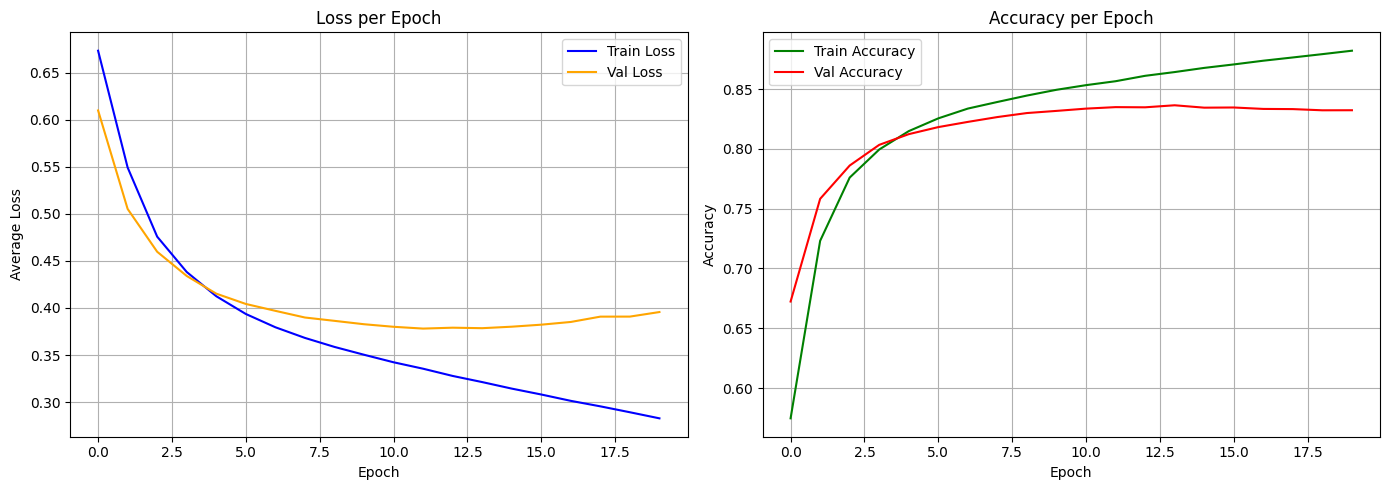

In [13]:
embed_cnt = 16          # word embedding dimension
pos_cnt = 16            # positional encoding dimension
feature_cnt = 16        # total feature dimension (d)
k = 8                   # query/key dimension (low-rank)
d_v = feature_cnt       # output value dimension (could be different if desired)

vocab_len = max(vocab.values()) + 1 # maximal value (index) of a token

class SelfAttention(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.Q = torch.nn.Linear(feature_cnt, k)        # query projection d x k
        self.K = torch.nn.Linear(feature_cnt, k)        # key projection d x k
        self.V = torch.nn.Linear(feature_cnt, d_v)      # value projection d x d_v

    def forward(self, features):                        # size: batch, words, d
        queries = self.Q(features)                      # size: batch, words, k
        keys = self.K(features)                         # size: batch, words, k
        values = self.V(features)                       # size: batch, words, d_v

        # Compute energy scores:
        energies = queries @ keys.transpose(-2, -1)     # size: batch, words, words
        energies = energies / (k ** 0.5)                # it is an additional rescale helping the stability

        # Normalize energies into attention weights
        attention = F.softmax(energies, dim=-1)         # size: batch, words, words

        # Apply attention weights to values:
        output = attention @ values                     # size: batch, words, d_v

        return output

class Net_SelfAttention(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_len, embed_cnt)
        self.attention = SelfAttention()
        self.classifier = torch.nn.Linear(d_v, 1)

    def forward(self, index):                            # size: batch, words
        features = self.embedding(index) + S             # size: batch, words, d

        # Attend and pool original features using attention weights
        attended = self.attention(features)              # size: batch, words, d_v
        pooled = attended.mean(dim = -2)                 # size: batch, d_v  # average across words

        output = self.classifier(pooled)                 # size: batch, 1
        logits = output.squeeze(-1)                      # size: batch
        return logits

# Instantiate and train
net_selfatt = Net_SelfAttention()
train_loss, val_loss, train_acc, val_acc = train_model(net_selfatt, train_loader, val_loader, epochs=20)
plot_training_curves(train_loss, val_loss, train_acc, val_acc)
